In [244]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [245]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [246]:
DATASET_PATH = './train.csv'

MODEL_FILE_PATH = './models/model.pkl'

In [247]:
df = pd.read_csv(DATASET_PATH, sep=',')

# Уменьшение объема памяти датасета

In [248]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col]. astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                       
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                       df[col] = df[col].astype(np.float32)
                else:
                       df[col] = df[col].astype(np.float64)

    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:1f}%'.format(100 * (start_mem - end_mem) / start_mem))
                       
    return df

In [249]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 54.995600%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


# Визуализация данных

In [250]:
matplotlib.rcParams.update({'font.size': 14}) # размер шрифта на всех графиках

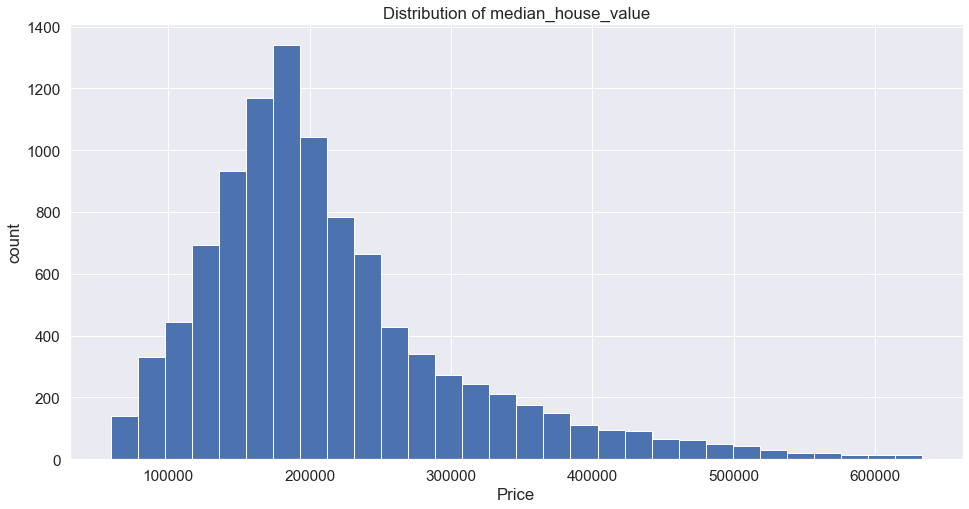

In [251]:
plt.figure(figsize=(16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of median_house_value')
plt.show()

### Анализ признаков

In [252]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [253]:
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027313,NaN,10.0,10.0,0.075424,NaN
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0
3,1.0,40.409908,NaN,1.0,22.0,0.007122,NaN
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,NaN


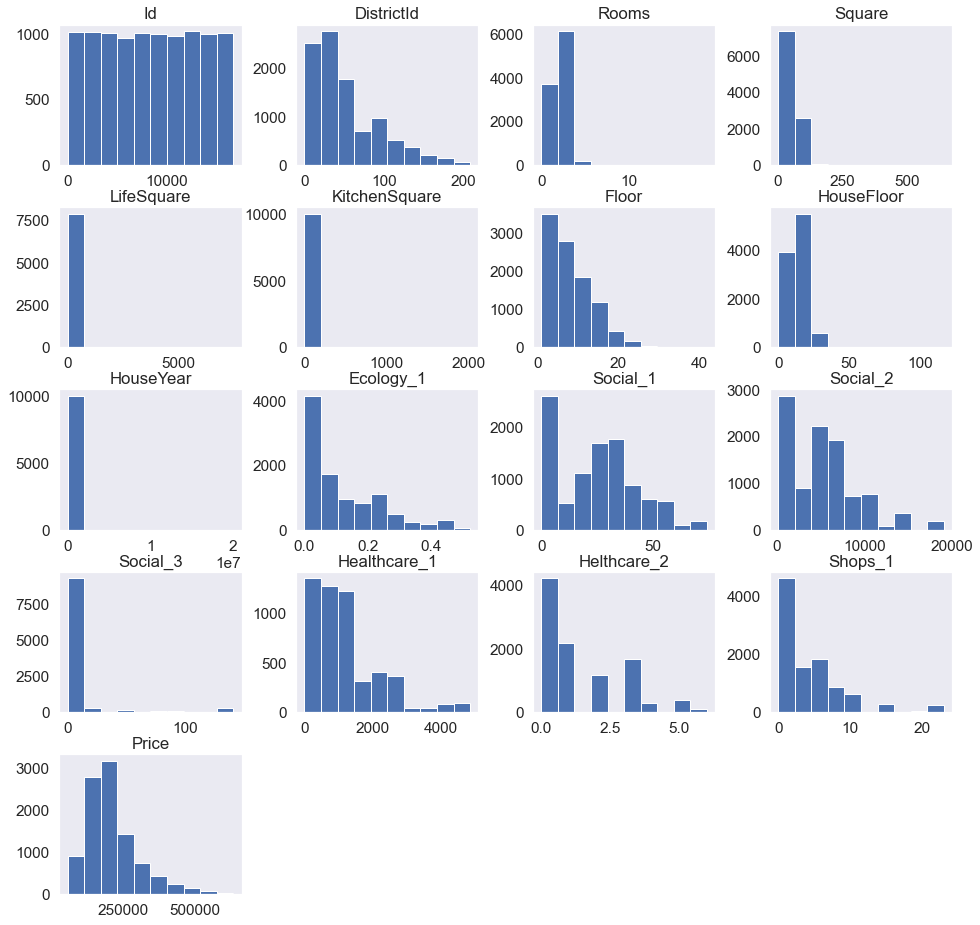

In [254]:
df.hist(figsize=(16, 16), bins=10, grid=False)
plt.show()

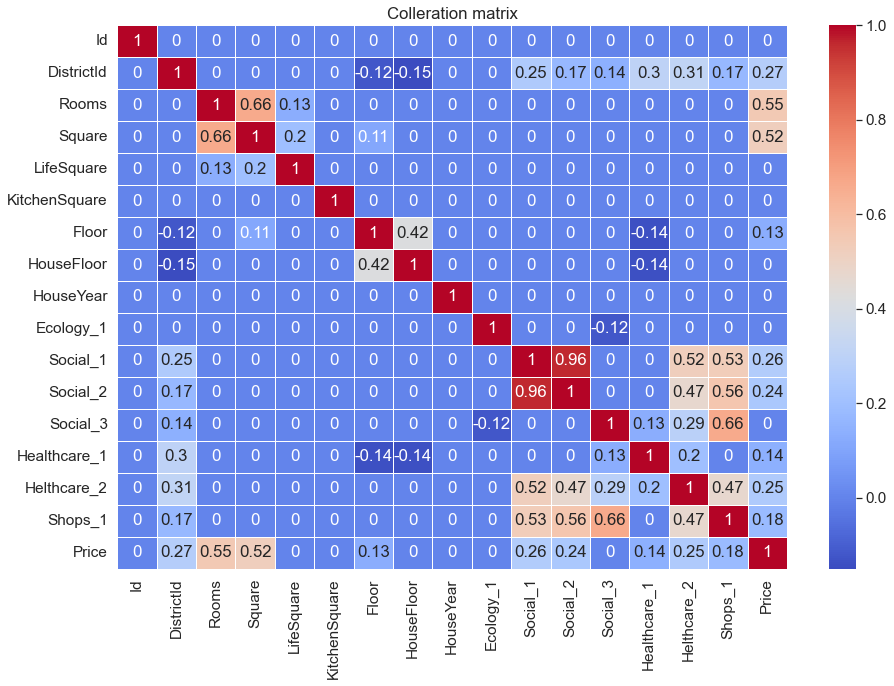

In [255]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='coolwarm')

plt.title('Colleration matrix')
plt.show()

In [256]:
scaler = RobustScaler()

### Предобработка данных и Feature engineering

In [258]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.binary_to_numbers = None
        self.housefloor_max_value = None
        self.house_year_min_value = None
        self.kitchen_max_value = None
        self.kitchen_min_value = None
        self.LifeSquare_Square = None
        self.square_max_value = None
        self.square_min_value = None
        self.lifesquare_max_value = None
        self.lifesquare_min_value = None
        self.district_size = None
        self.med_price_by_square_district = None
        self.med_price_by_square_district_median = None
        
    def fit(self, X, y=None):
        
        df = X.copy()
        
       ## square, district
        if y is not None:        
            df['Price'] = y.values
            
            df = square_to_cat(df)
            
            self.med_price_by_square_district = df.groupby(['square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareDistrict'})
            self.med_price_by_square_district_median = self.med_price_by_square_district['MedPriceBySquareDistrict'].median()
        
        # Расчет медиан
        
        self.medians = X.median()
        
        # binary_to_numbers
        
        self.binary_to_numbers = {'A': 1, 'B': 0}
        
        # Отношение медианы жилой площади к Общей площади для вычисления замены пропусков
        
        self.LifeSquare_Square = (self.medians['LifeSquare'] / self.medians['Square'])
        
        # Отношение медианы площади кухни к Общей площади для замены
        
        self.Kitchen_Square = self.medians['KitchenSquare'] / self.medians['Square']
        
        # Максимальные и минимальные значения признаков
        
        self.square_max_value = 120
        self.square_min_value = 20
        
        
#         self.lifesquare_max_value = np.quantile(X['LifeSquare'], q=.985)
#         self.lifesquare_min_value = 10
        
        self.housefloor_max_value = 90
        self.house_year_min_value = datetime.now().year - 100
        
        self.kitchen_max_value = np.quantile(X['KitchenSquare'], q=.975)
        self.kitchen_min_value = 3

        
        
    def transform(self, X, y=None):
        """Трансформация данных"""

        
    # 1. Пропуски
    
        X['LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        X['LifeSquare'].fillna((self.LifeSquare_Square * X['Square']), inplace=True)
        
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        
        X['Square'].fillna((X['LifeSquare'] * 1.6), inplace=True)
        
        X['KitchenSquare'].fillna((self.Kitchen_Square * X['Square']), inplace=True)
        
        # Заполнение пропусков медианами
        
        X.fillna(self.medians, inplace=True)
        
    # 2. Исключение ненужных столбцов
    
        X['Id'] = X['Id'].astype('str')
        
        
    # 3. Выбросы (outliers)

        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 0), 'Rooms'] = 1
        X.loc[(X['Rooms'] > 5), 'Rooms'] = 4
            
        # Square
        
        condition = (X['Square'] > self.square_max_value) | (X['Square'] <= self.square_min_value)
        X['Square_outlier'] = 0
        X.loc[condition, 'Square_outlier'] = 1
        X.loc[condition, 'Square'] = X['LifeSquare'] * 1.6  #средняя площадь по базе, в зависмости от LifeSquare


        # KitchenSquare
        condition = (X['KitchenSquare'] > self.kitchen_max_value) | (X['KitchenSquare'] < self.kitchen_min_value)
        X['KitchenSquare_outlier'] = 0
        X.loc[condition, 'KitchenSquare_outlier'] = 1
        X.loc[condition, 'KitchenSquare'] = self.Kitchen_Square * X['Square']
        

        # LifeSquare
        condition = (X['LifeSquare'] >= (X['Square'] - X['KitchenSquare'])) |\
            (X['LifeSquare'] < self.lifesquare_min_value) |\
            (X['LifeSquare'] > self.lifesquare_max_value)
        X['LifeSquare_outlier'] = 0
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = self.LifeSquare_Square * X['Square']
        

        # HouseFloor
        condition = (X['HouseFloor'] < 1) | (X['HouseFloor'] > self.housefloor_max_value)
        X['HouseFloor_outlier'] = 0
        X.loc[condition, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] < 1, 'HouseFloor'] = 1
        X.loc[X['HouseFloor'] > self.housefloor_max_value, 'HouseFloor'] = self.medians['HouseFloor']
        

        # Floor
        X['Floor_outlier'] = 0
        X.loc[(X['HouseFloor'] < X['Floor']) | (X['Floor'] < 1), 'Floor_outlier'] = 1
        X.loc[(X['HouseFloor'] < X['Floor']), 'Floor']  = X['HouseFloor']
        X.loc[(X['Floor'] < 1), 'Floor'] = 0
        
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[(X['HouseYear'] > current_year) | (X['HouseYear'] < self.house_year_min_value), 'HouseYear_outlier'] = 1
        X.loc[(X['HouseYear'] > current_year), 'HouseYear'] = current_year
        X.loc[(X['HouseYear'] < self.house_year_min_value), 'HouseYear'] = self.house_year_min_value
        
        

        
    # 4. Изменение типа
        
         # Ecology_2
        X['Ecology_2'] = X['Ecology_2'].replace(self.binary_to_numbers)   
        
        # Shops_2
        X['Shops_2'] = X['Shops_2'].replace(self.binary_to_numbers)

        # Ecology_3
        X['Ecology_3'] = X['Ecology_3'].replace(self.binary_to_numbers)
        
    # 5. Новые фичи (features)
    
        # Target encoding
        
        X = square_to_cat(X)
        
        if self.med_price_by_square_district is not None:
            X = X.merge(self.med_price_by_square_district, on=['square_cat'], how='left')
            X['MedPriceBySquareDistrict'].fillna(self.med_price_by_square_district_median, inplace=True)
    
    
        # Слияние признаков Social
        
        pca = PCA(n_components=1, random_state=22)
        social_scaled = pd.DataFrame(scaler.fit_transform(X[['Social_1', 'Social_2']]))
        X['Social'] = pca.fit_transform(social_scaled)
    

        # Отношение LifeSquare/Square
        X['LifeSquare/Square'] = (X['LifeSquare'] / X['Square'])
        
        # Отношение Rooms/Square
        X['Square/Rooms'] = (X['Square'] / X['Rooms'])

        # Нежилая площадь
        X['NonresidentialSquare'] = X['Square'] - X['LifeSquare'] - X['KitchenSquare']
        
        pca = PCA(n_components=1, random_state=22)
        square_scaled = pd.DataFrame(scaler.fit_transform(X[['DistrictId', 'Square']]))
        X['Square_District'] = pca.fit_transform(square_scaled)
        
        
        pca = PCA(n_components=1, random_state=22)
        ecology_scaled = pd.DataFrame(scaler.fit_transform(X[['Ecology_1', 'Ecology_2', 'Ecology_3']]))
        X['Ecology'] = pca.fit_transform(ecology_scaled)
        
        pca = PCA(n_components=1, random_state=22)
        shops_scaled = pd.DataFrame(scaler.fit_transform(X[['Shops_1', 'Shops_2']]))
        X['Shops'] = pca.fit_transform(shops_scaled)
        
        
        # Категоризация применение
        
        X['house_age'] = 2021 - X['HouseYear']
        
        X = age_to_cat(X)
        X = floor_to_cat(X)
        
        X.drop('Square', axis=1, inplace=True)
        
        return X
         

# Категоризация по площади

def square_to_cat(X):
    
    X['square_cat'] = 0
    
    for en in range(4, 30):
        n = 5
        X.loc[(X['Square'] >= ((en - 1) * n)) & (X['Square'] < ((en + 1) * n)), 'square_cat'] = en
    
    return X

        
# Категоризация этажности

def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[(X['Floor'] == 1), 'floor_cat'] = 1
    X.loc[(X['Floor'] >= 2) & (X['Floor'] < 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] >= 5) & (X['Floor'] < 10), 'floor_cat'] = 3
    X.loc[(X['Floor'] >= 10) & (X['Floor'] < 15), 'floor_cat'] = 4
    X.loc[(X['Floor'] >= 15) & (X['Floor'] < 25), 'floor_cat'] = 5
    X.loc[(X['Floor'] >= 25), 'floor_cat'] = 6

    return X


# Категоризация возраста дома


def age_to_cat(X):

    X['age_cat'] = 0

    X.loc[X['house_age'] <= 5, 'age_cat'] = 1
    X.loc[(X['house_age'] > 5) & (X['house_age'] <= 10), 'age_cat'] = 2
    X.loc[(X['house_age'] > 10) & (X['house_age'] <= 15), 'age_cat'] = 3
    X.loc[(X['house_age'] > 15) & (X['house_age'] <= 25), 'age_cat'] = 4
    X.loc[(X['house_age'] > 25) & (X['house_age'] <= 40), 'age_cat'] = 5
    X.loc[(X['house_age'] > 40) & (X['house_age'] <= 45), 'age_cat'] = 6
    X.loc[(X['house_age'] > 45) & (X['house_age'] <= 55), 'age_cat'] = 7
    X.loc[(X['house_age'] > 55), 'age_cat'] = 8

    return X

        
        

### Разделение данных

In [259]:
X = df.drop(columns='Price')

In [260]:
y = df['Price']

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

In [262]:
pipe = DataPipeline()
pipe.fit(X_train, y_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [263]:
pd.set_option('display.max_columns', None)

In [264]:
X_train.head(5)

,Id,DistrictId,Rooms,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,square_cat,MedPriceBySquareDistrict,Social,LifeSquare/Square,Square/Rooms,NonresidentialSquare,Square_District,Ecology,Shops,house_age,age_cat,floor_cat
0,5355,74,1.0,33.633324,6.182832,1.0,1.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,0,1,0,0,1,1,1,1,0,11,202852.921875,-0.935794,0.624395,53.865501,14.049345,-0.143042,-0.247197,-0.440351,44,6,1
1,11764,93,3.0,105.595856,19.392939,3.0,3.0,1977,0.004949,0,0,0,186,0,900.0,0,0,0,1,1,0,1,1,0,0,1,0,0,230669.343750,-1.238105,0.625000,56.317791,43.964577,4.546021,-0.648262,-0.839937,44,6,2
2,15528,66,3.0,47.728355,12.000000,17.0,17.0,2001,0.111627,0,0,50,12238,8,1970.0,2,3,0,0,0,0,0,0,0,0,0,0,16,311232.125000,1.500104,0.600435,26.496527,19.761223,0.923022,-0.044207,-0.240557,20,4,5
3,10578,22,2.0,28.475996,5.000000,3.0,5.0,1962,0.118537,0,0,30,6207,1,1183.0,1,0,0,0,0,0,0,0,0,0,0,0,10,184273.968750,0.241962,0.624773,22.789080,12.102163,-0.389382,-0.005080,-0.839937,59,8,2
4,1490,31,1.0,20.454700,6.000000,1.0,9.0,1974,0.151346,0,1,32,5889,10,830.0,4,1,0,0,0,0,0,0,0,0,0,0,8,165061.906250,0.243822,0.571300,35.803776,9.349075,-0.806766,0.239009,-0.640144,47,7,1


In [265]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 6699
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        6700 non-null   object 
 1   DistrictId                6700 non-null   int16  
 2   Rooms                     6700 non-null   float32
 3   LifeSquare                6700 non-null   float32
 4   KitchenSquare             6700 non-null   float32
 5   Floor                     6700 non-null   float32
 6   HouseFloor                6700 non-null   float32
 7   HouseYear                 6700 non-null   int32  
 8   Ecology_1                 6700 non-null   float32
 9   Ecology_2                 6700 non-null   int64  
 10  Ecology_3                 6700 non-null   int64  
 11  Social_1                  6700 non-null   int8   
 12  Social_2                  6700 non-null   int16  
 13  Social_3                  6700 non-null   int16  
 14  Healthca

In [266]:
feature_names_for_stand = X_train.select_dtypes(include=['float64','float32', 'float16', 'int64', 'int32', 'int16', 'int8']).columns

target_name = 'Price'

### Построение модели

In [267]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [268]:
X_train

,Id,DistrictId,Rooms,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,square_cat,MedPriceBySquareDistrict,Social,LifeSquare/Square,Square/Rooms,NonresidentialSquare,Square_District,Ecology,Shops,house_age,age_cat,floor_cat
0,5355,74,1.0,33.633324,6.182832,1.0,1.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,0,1,0,0,1,1,1,1,0,11,202852.921875,-0.935794,0.624395,53.865501,14.049345,-0.143042,-0.247197,-0.440351,44,6,1
1,11764,93,3.0,105.595856,19.392939,3.0,3.0,1977,0.004949,0,0,0,186,0,900.0,0,0,0,1,1,0,1,1,0,0,1,0,0,230669.343750,-1.238105,0.625000,56.317791,43.964577,4.546021,-0.648262,-0.839937,44,6,2
2,15528,66,3.0,47.728355,12.000000,17.0,17.0,2001,0.111627,0,0,50,12238,8,1970.0,2,3,0,0,0,0,0,0,0,0,0,0,16,311232.125000,1.500104,0.600435,26.496527,19.761223,0.923022,-0.044207,-0.240557,20,4,5
3,10578,22,2.0,28.475996,5.000000,3.0,5.0,1962,0.118537,0,0,30,6207,1,1183.0,1,0,0,0,0,0,0,0,0,0,0,0,10,184273.968750,0.241962,0.624773,22.789080,12.102163,-0.389382,-0.005080,-0.839937,59,8,2
4,1490,31,1.0,20.454700,6.000000,1.0,9.0,1974,0.151346,0,1,32,5889,10,830.0,4,1,0,0,0,0,0,0,0,0,0,0,8,165061.906250,0.243822,0.571300,35.803776,9.349075,-0.806766,0.239009,-0.640144,47,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,11821,27,1.0,26.021620,4.783569,14.0,19.0,1977,0.211401,0,0,9,1892,0,900.0,0,1,0,1,1,0,0,1,0,0,0,0,9,162257.750000,-0.807582,0.624395,41.674965,10.869776,-0.558591,0.520754,-0.640144,44,6,4
6696,2286,99,2.0,28.737215,6.000000,9.0,9.0,1972,0.012339,0,0,35,5776,1,2078.0,2,4,0,0,0,0,0,0,0,0,0,0,10,184273.968750,0.295597,0.607491,23.652382,12.567549,-0.457398,-0.606420,-0.040764,49,7,3
6697,16726,119,2.0,32.964130,6.000000,9.0,9.0,1973,0.333892,0,0,30,6564,1,900.0,0,0,0,0,1,0,0,0,0,0,1,0,11,202852.921875,0.290004,0.642404,25.656851,12.349571,-0.328939,1.214345,-0.839937,48,7,3
6698,15625,34,3.0,55.986717,10.292068,19.0,25.0,2016,0.069753,0,0,53,13670,4,900.0,1,11,0,0,1,0,0,1,1,0,0,0,18,273402.500000,1.759791,0.624395,29.888536,23.386826,1.398374,-0.281315,1.357789,5,1,5


In [269]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                       max_depth=5,
                                       min_samples_leaf=50,
                                       random_state=22,
                                       n_estimators=100)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)

Train R2:	0.8082
Test R2:	0.7294


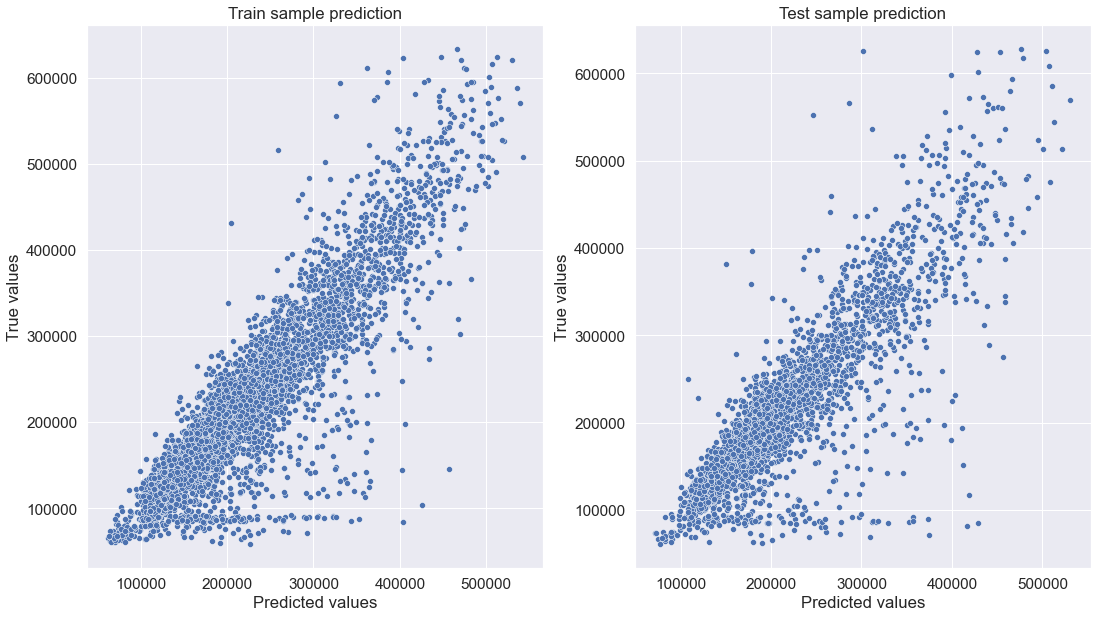

In [270]:
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Настройка и оценка финальной модели

#### Кросс-валидация

In [271]:
# cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

In [272]:
# np.round(cv_score.mean(), 4)

In [273]:
# %%time
# params = {'n_estimators':[150],
#          'max_depth':[6],
#          'min_samples_leaf':[5, 10, 15, 20]}

# gs = GridSearchCV(gb_model, params,
#                   scoring='r2',
#                   cv=KFold(n_splits=5,
#                           random_state=21,
#                           shuffle=True),
#                   n_jobs=-1
#                  )
# gs.fit(X_train, y_train)
                  

Wall time: 36.4 s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse', max_depth=5,
                                                 min_samples_leaf=50,
                                                 random_state=22),
             n_jobs=-1,
             param_grid={'max_depth': [6], 'min_samples_leaf': [5, 10, 15, 20],
                         'n_estimators': [150]},
             scoring='r2')

In [274]:
# gs.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 150}

In [275]:
# gs.best_score_

0.740199510907531

#### Обучение и оценка модели

In [278]:
final_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=15,
                                     random_state=42,  
                                     n_estimators=150)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=15,
                          n_estimators=150, random_state=42)

Train R2:	0.8675
Test R2:	0.7379


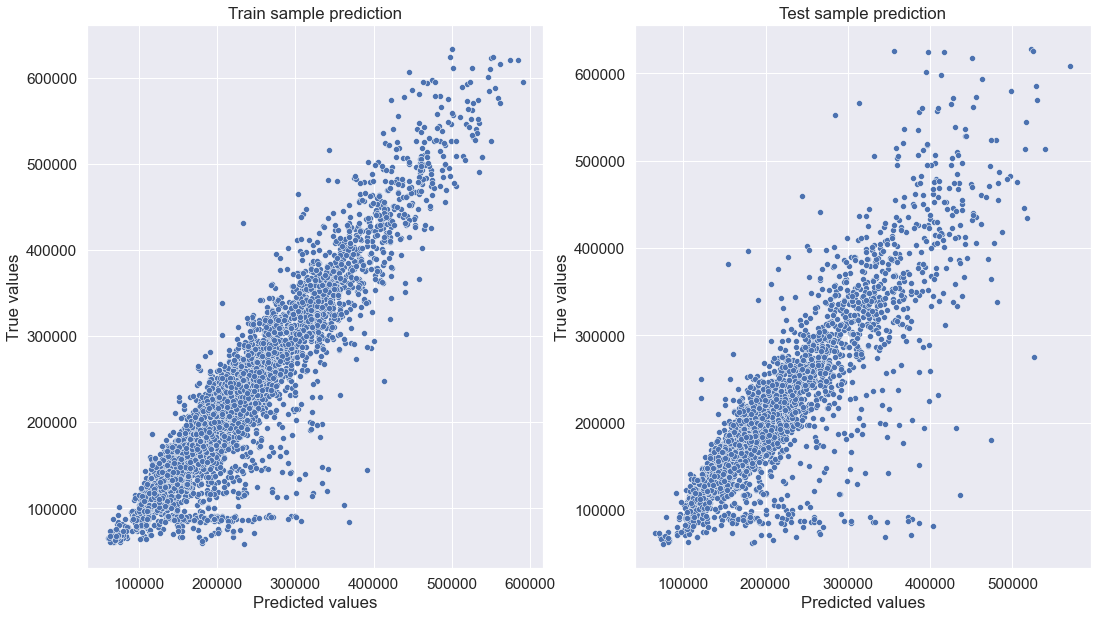

In [279]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Анализ прогнозов

In [280]:
final_model.feature_importances_

array([3.75675565e-03, 6.26154367e-02, 7.00795328e-02, 1.03454880e-01,
       1.50036853e-02, 6.00693697e-03, 1.46660563e-02, 1.42419603e-02,
       2.32237187e-02, 6.74316273e-05, 5.68331361e-04, 7.05886226e-02,
       4.33007975e-02, 6.74918224e-02, 2.09793428e-02, 1.72465781e-03,
       6.30193662e-03, 2.13959832e-04, 1.79395832e-05, 6.55506892e-04,
       0.00000000e+00, 5.65627323e-04, 6.13610625e-03, 3.03071876e-04,
       7.19131366e-06, 1.18162033e-04, 6.76907805e-06, 4.43183050e-02,
       2.21562008e-01, 7.08919450e-02, 6.87104009e-03, 1.46334956e-02,
       1.60460621e-02, 5.32097371e-02, 2.13345417e-02, 6.30066590e-03,
       1.10396181e-02, 1.03694219e-03, 6.59399534e-04])

In [281]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [282]:
feature_importances

,feature_name,importance
28,MedPriceBySquareDistrict,0.221562
3,LifeSquare,0.103455
29,Social,0.070892
11,Social_1,0.070589
2,Rooms,0.070080
13,Social_3,0.067492
1,DistrictId,0.062615
33,Square_District,0.053210
27,square_cat,0.044318
12,Social_2,0.043301


### Сохранение модели

In [1603]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [1604]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=70,
                          n_estimators=150, random_state=42)

Kaggle

In [1605]:
DATASET_TEST = './test.csv'

df_test = pd.read_csv(DATASET_TEST, sep=',')

In [1606]:
df_test = pipe.transform(df_test)

In [1607]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Social,LifeSquare/Square,Square/Rooms,NonresidentialSquare,Square_District,Ecology,house_age,age_cat,floor_cat
0,4567,44,1.0,36.847630,19.094182,5.000000,5.0,9.0,1970,0.036122,0,0,24,4378,0,1036.0,1,1,0,0,0,0,0,0,0,0,0,0,-0.158564,0.518193,36.847630,12.753448,-0.378986,-0.644668,51,7,3
1,5925,62,1.0,42.493907,16.532962,10.000000,7.0,17.0,2017,0.072158,0,0,2,629,1,900.0,0,0,1,0,1,0,0,0,1,0,0,0,-1.130429,0.389067,42.493907,15.960945,-0.496998,-0.885208,4,1,3
2,960,27,2.0,59.463678,37.128794,9.000000,19.0,19.0,1977,0.211401,0,0,9,1892,0,900.0,0,1,0,1,1,0,0,0,0,0,0,0,-0.811739,0.624395,29.731839,13.334884,0.420764,-0.644668,44,6,5
3,3848,23,3.0,49.646030,33.893825,6.000000,2.0,2.0,1965,0.014073,0,0,2,475,0,900.0,0,0,0,0,1,0,0,0,0,0,0,0,-1.151200,0.682710,16.548677,9.752204,0.236109,-0.844503,56,8,2
4,746,74,1.0,53.837056,33.615562,6.179568,8.0,17.0,1977,0.309479,0,0,35,7715,4,990.0,0,6,0,1,0,0,0,1,0,0,0,0,0.524627,0.624395,53.837056,14.041926,-0.389024,0.354503,44,6,3


In [1608]:
test_preds = final_model.predict(df_test)

In [1609]:
submission = pd.DataFrame(df_test['Id'])
submission['Price'] = pd.DataFrame(test_preds)
submission

,Id,Price
0,4567,168172.984114
1,5925,117655.358197
2,960,154711.115672
3,3848,127011.491666
4,746,182590.164808
...,...,...
4995,10379,170029.736650
4996,16138,353694.351635
4997,3912,143995.888480
4998,5722,199634.344759


In [1610]:
submission.set_index('Id', inplace=True)

In [1611]:
submission.describe()

,Price
count,5000.000000
mean,216047.325758
std,77040.646534
min,64640.231362
25%,164241.118143
50%,195716.640692
75%,251496.763174
max,530414.504796


In [1612]:
submission.to_csv('./submission.csv', sep=',')